In [53]:
# model orbits with python and jupyter widgets

In [54]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
from pylab import *
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [80]:
def convert_r_v(r, v): # converts position and velocity vectors, r and v, into orbital elements
    unit_i = np.array([1, 0, 0])
    unit_j = np.array([0, 1, 0])
    unit_k = np.array([0, 0, 1])
    mag_r = np.linalg.norm(r)
    mag_v = np.linalg.norm(v)
    mu = 1
    h = np.cross(r, v)
    n = np.cross(unit_k, h)
    mag_n = np.linalg.norm(n)
    mag_h = np.linalg.norm(h)
    p = mag_h**2
    e = (1 / mu) * ((r * (mag_v**2 - (mu / mag_r))) - (v * np.dot(r, v)))
    mag_e = np.linalg.norm(e)
    i = np.arccos((np.dot(h, unit_k)) / mag_h)
    if mag_n == 0:
        little_omega = 'none'
        big_omega = 'none'
    else:
        little_omega = np.arccos(np.dot(n, e) / (mag_n * mag_e))
        big_omega = np.arccos(np.dot(n, unit_i) / mag_n)
    nu = np.arccos(np.dot(e, r) / (mag_e * mag_r))
    return (p, mag_e, i, little_omega, big_omega, nu)

def convert_orbital_perifocal(p, e, nu): # converts orbital elements into position and velocity vectors in the perifocal frame
    mu = 1
    mag_r = p / (1 + (e * np.cos(nu)))
    r = np.array([mag_r * np.cos(nu), mag_r * np.sin(nu), 0])
    v = np.array([((mu / p) ** (1 / 2)) * (-1 * np.sin(nu)), ((mu / p) ** (1 / 2)) * (e + np.cos(nu)), 0])
    return r, v

def convert_orbital_geocentric(p, e, i, little_omega, big_omega, nu): # converts orbital elements into perifocal then geocentric
    r, v = convert_orbital_perifocal(p, e, nu)
    if big_omega == 'none' or little_omega == 'none':
        return r, v
    else:
        trans_matrix = np.array([[(np.cos(big_omega) * np.cos(little_omega)) - (np.sin(big_omega) * np.sin(little_omega) * np.cos(i)),
                                  (-1 * np.cos(big_omega) * np.sin(little_omega)) - (np.sin(big_omega) * np.cos(little_omega) * np.cos(i)),
                                  np.sin(big_omega) * np.sin(i)],
                                 [(np.sin(big_omega) * np.cos(little_omega)) + (np.cos(big_omega) * np.sin(little_omega) * np.cos(i)),
                                  (-1 * np.sin(big_omega) * np.sin(little_omega)) + (np.cos(big_omega) * np.cos(little_omega) * np.cos(i)),
                                  -1 * np.cos(big_omega) * np.sin(i)],
                                 [np.sin(little_omega) * np.sin(i), np.cos(little_omega) * np.sin(i), np.cos(i)]])
        r = np.dot(r, np.transpose(trans_matrix))
        v = np.dot(v, np.transpose(trans_matrix))
        x = np.array([r[0],r[1],r[2],v[0],v[1],v[2]])
        return x

In [75]:
f = interact(convert_orbital_geocentric, p = (0.01, 15), e = (0.0, 1.0), i = (0, 359), little_omega = (0, 359), big_omega = (0, 359), nu = (0, 359))
f

array([  1.09386255e+01,   6.67032593e+00,   3.45374969e-01,
        -1.99664456e-01,   7.37623352e-02,   1.05541433e-02])

In [57]:
import scipy.integrate as integrate

<IPython.core.display.Javascript object>


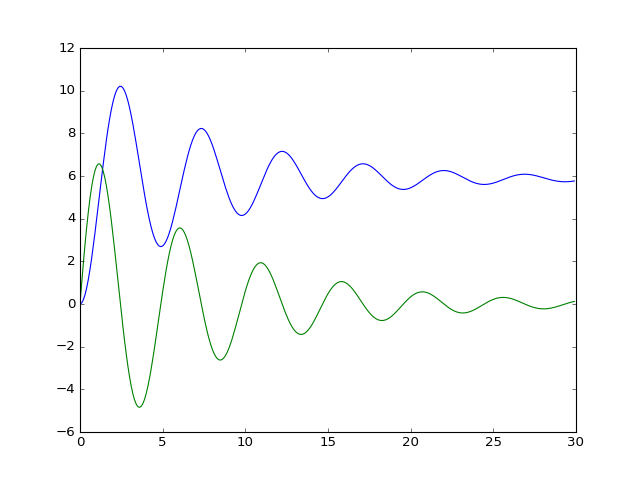

In [82]:
from scipy.integrate import odeint

def MassSpring(state,t):
  # unpack the state vector
  x = state[0]
  xd = state[1]

  # these are our constants
  k = -2.5 # Newtons per metre
  m = 1.5 # Kilograms
  c = .25
  g = 9.8 # metres per second

  # compute acceleration xdd
  xdd = ((k*x)/m) + g - c * xd

  # return the two state derivatives
  return [xd, xdd]

state0 = [0.0, 0.0]
t = arange(0.0, 30.0, 0.1)

state = odeint(MassSpring, state0, t)
fig = plt.figure()
fig.add_subplot(111)
plot(t, state)
# xlabel('TIME (sec)')
# ylabel('STATES')
# title('Mass-Spring System')
# legend(('$x$ (m)', '$\dot{x}$ (m/sec)'))

In [83]:
G = 6.67408 * 10**(-11)
M = 5.972 * 10**24
def TwoBody(state, t):
    #unpack state vector
    xd = state[3]
    yd = state[4]
    zd = state[5]
    xdd = -(M*G)/((state[0]**2 + state[1]**2 + state[2]**2)**(1/2))**3 * state[0]
    ydd = -(M*G)/((state[0]**2 + state[1]**2 + state[2]**2)**(1/2))**3 * state[1]
    zdd = -(M*G)/((state[0]**2 + state[1]**2 + state[2]**2)**(1/2))**3 * state[2]
    
    return [xd, yd, zd, xdd, ydd, zdd]

state0 = convert_orbital_geocentric(3, .7, 172, 228, 75, 312)
t = arange(0.0, 60.0, .1)

state = odeint(TwoBody, state0, t)
fig = plt.figure()
fig.add_subplot(111, projection = '3d')
plot(t, state)

C:\Program Files\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>

ValueError: setting an array element with a sequence.